In [53]:
from numpy import sin, cos, pi, array
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import math


metadata = dict(title='Rotating Bot', artist='Pete Florence',
        comment='Rotate time')
writer = animation.AVConvWriter(fps=20, metadata=metadata, bitrate=5000)


# constant velocity
v = 1

def derivs(state, t):

    dqdt = np.zeros_like(state)
    
    u = np.cos(state[2])
    
    dqdt[0] = 0 # rotating laser bot can't move
    
    dqdt[1] = 0 # rotating laser bot can't move

    dqdt[2] = 0.2 # constant for now, but later will be u
    #dqdt[2] = sin(t) # constant for now, but later will be u

    return dqdt

# create a time array from 0...30 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 5, dt)

# initial positions
# x and y are position of origin.  We move the origin, not the plane, so that the plane stays in the same spot in the plot.
# psi is yaw, and psidot is yawdot of plane
x = 0.0
y = 0.0
psi = -10.0

rad = pi/180.0

# initial state
state = np.array([x, y, psi*rad])

print "integrating..."
# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
print "done"

xworld = y[:,0]
yworld = y[:,1]
psiworld = y[:,2]

from ObstacleField import ObstacleField
from Obstacle import Obstacle

obsField = ObstacleField()
obsField.randomField(M=11)
for i in obsField.ObstaclesList:
    i.computeTraj(psiworld,xworld,yworld)

integrating...
done


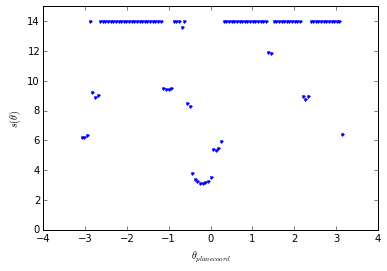

In [54]:
# Add laser
from LineCircleIntersect import intersect
laserLines = []
approxLines = []
D = 100 # Number of discrete data points from laser
laseAngles = np.linspace(-math.pi,math.pi,D+1)[0:D]

#S_max
S_maxdist = 14
S_max_t = np.linspace(-math.pi,math.pi,100)
S_max_x = S_maxdist*np.cos(S_max_t)
S_max_y = S_maxdist*np.sin(S_max_t)

xlist = []
ylist = []

laserDepths = laseAngles * 0.0


# Find laser depths at a certain point in time
# Need to not have this code copied
i = 0
for lasenum in range(len(laseAngles)):

    x_laser_endpoint = S_maxdist*math.cos(laseAngles[lasenum])
    y_laser_endpoint = S_maxdist*math.sin(laseAngles[lasenum])

    origin = np.array((0,0))
    laser_endpoint = np.array((x_laser_endpoint,y_laser_endpoint))
    for obs in obsField.ObstaclesList:
        Q = np.array((obs.xtraj[i],obs.ytraj[i]))
        r = obs.radius
        _, pt = intersect(origin,laser_endpoint,Q,r)
        if pt is not None:
            if (pt[0]**2 + pt[1]**2 < x_laser_endpoint**2 + y_laser_endpoint**2):
                x_laser_endpoint = pt[0]
                y_laser_endpoint = pt[1]

    depth = math.sqrt(x_laser_endpoint**2 + y_laser_endpoint**2)
    laserDepths[lasenum] = depth

 
%matplotlib inline
from coordTransforms import transformStandardPolarTheta_to_PlaneTheta
laseAngles2 = laseAngles * 0
for i in range(len(laseAngles)):
    laseAngles2[i] = transformStandardPolarTheta_to_PlaneTheta(laseAngles[i])

plt.plot(laseAngles2,laserDepths,'.')
plt.xlabel(r'$\theta_{plane coord}$')
plt.ylabel(r'$s(\theta)$')
plt.axis([-4, 4, 0, 15])
plt.show()

import csv
with open('laserdata.csv', 'wb') as csvfile:
    laserwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(laserDepths)):
        laserwriter.writerow([laseAngles2[i], laserDepths[i]])

(100, 13)
weighted numpy polynomial regression weights for N = 12
[  3.64221282e+00   5.52861800e+00   1.44076848e+01   4.39177312e-01
  -6.74628355e+00  -2.33734188e+00   1.29753419e+00   6.83710093e-01
  -1.00576652e-01  -7.01246789e-02   1.32871937e-03   2.41195545e-03
   1.08480111e-04]


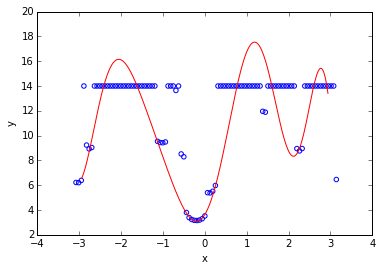

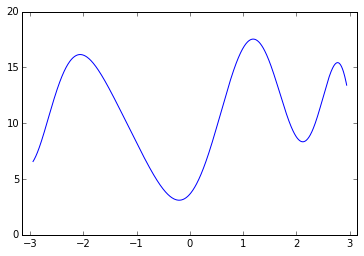

In [55]:
import scipy.optimize as opt
from linear_regression import LinearRegression

def plot(lr,w):
    # plot sin(2*phi*x) in green
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    lr_temp = LinearRegression(x,x,lr.numFeatures-1)
    reg_prediction = np.dot(lr_temp.phi,w)
    plt.plot(x, reg_prediction, color='r')
    plt.scatter(lr.x, lr.y, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    


N = 12
lr = LinearRegression(laseAngles2,laserDepths,N)
print np.shape(lr.phi)

print "weighted numpy polynomial regression weights for N = " + str(N)
weights = laserDepths * 1.0
#print weights
for index, value in enumerate(weights):
    weights[index] = (1/value)**4
#print weights
# an attempt to weight things in front more heavily 
# weights[len(weights)/4:3*len(weights)/4] = 10.0
w = np.polynomial.polynomial.polyfit(laseAngles2, laserDepths, N, w=weights)
print w
plot(lr,w)

def horner(x, weights):
    coefficients = weights[::-1]
    result = 0
    for i in coefficients:
        result = result * x + i
    return result

# def evalPoly(x, weights):
#     result = 0.0
#     for i in range(len(weights)):
#         result = result + weights[i] * (x**i)
#     return result

def plotHorner(w):
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()
    
plotHorner(w)

In [56]:
# Define matrices that then I will need


def setUpQP():
    
    #A = feature matrix
    
    lr = LinearRegression(laseAngles2,laserDepths,N)
    A_pete = lr.phi
    
    #W = weighting matrix
    weights = laserDepths * 1.0
    for index, value in enumerate(weights):
        weights[index] = (1/value)**4
    W_pete = np.diag(weights)
    
    #b = vector of sensor measurements
    b_pete = laserDepths
    
    return np.matrix(A_pete), np.matrix(W_pete), np.matrix(b_pete)
    
A_pete, W_pete, b_pete = setUpQP()

print np.shape(A_pete)
print np.shape(A_pete.T)
print np.shape(A_pete * A_pete.T)
print np.shape(A_pete.T * A_pete)




(100, 13)
(13, 100)
(100, 100)
(13, 13)


     pcost       dcost       gap    pres   dres
 0: -5.9008e-01  3.7874e+02  3e+03  4e-01  4e+03
 1: -2.4589e-01 -3.3706e+01  3e+01  5e-03  4e+01
 2: -4.4293e-01 -1.8885e+00  1e+00  1e-04  1e+00
 3: -6.5894e-01 -7.8584e-01  1e-01  3e-14  6e-14
 4: -7.0252e-01 -7.3792e-01  4e-02  9e-15  4e-14
 5: -7.1146e-01 -7.2760e-01  2e-02  9e-15  3e-14
 6: -7.1618e-01 -7.1990e-01  4e-03  1e-14  7e-14
 7: -7.1691e-01 -7.1741e-01  5e-04  2e-14  3e-14
 8: -7.1695e-01 -7.1723e-01  3e-04  1e-14  2e-14
 9: -7.1699e-01 -7.1701e-01  1e-05  1e-14  9e-14
10: -7.1699e-01 -7.1699e-01  3e-07  1e-14  8e-14
Optimal solution found.
[[  3.52014922e+00]
 [  6.34954888e+00]
 [  1.55903822e+01]
 [ -5.12538795e+00]
 [ -1.12085049e+01]
 [  1.42783003e+00]
 [  3.76019412e+00]
 [ -2.36290796e-01]
 [ -6.38381026e-01]
 [  2.44104233e-02]
 [  5.30813667e-02]
 [ -1.05915733e-03]
 [ -1.71829485e-03]]


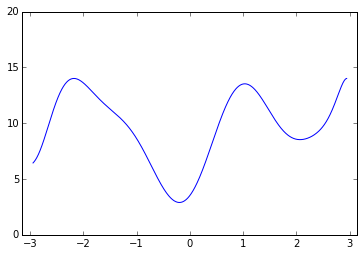

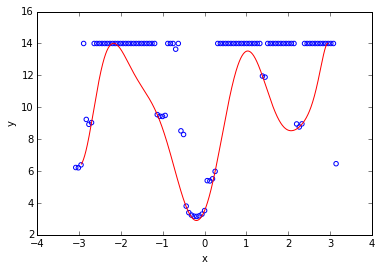

In [57]:
import cvxopt

# P = A^T W A
P = cvxopt.matrix(A_pete.T * W_pete * A_pete)

# q^T = -b^T A
# q = -A^T b
q = cvxopt.matrix(- A_pete.T * W_pete *b_pete.T)

# G = A
G = cvxopt.matrix(A_pete)

# h = b_pete
h = cvxopt.matrix(b_pete.T)

A_zeros = np.copy(A_pete)
A_zeros[::] = 0

b_zeros = np.copy(b_pete)
b_zeros[:] = 0

A = cvxopt.matrix(A_zeros)
b = cvxopt.matrix(b_zeros.T)

# find the solution 
solution = cvxopt.solvers.qp(P, q, G, h)

alpha = np.array(solution['x'])

print alpha

def plotHorner(w):
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y)
    plt.axis([-3.14, 3.14, 0, 20])
    plt.show()
    
plotHorner(alpha)


def plotConstrained(w):
    x = np.linspace(-math.pi+0.2,math.pi-0.2,1000)
    y = x * 0.0
    for index,val in enumerate(y):
        y[index] = horner(x[index],w)
    plt.plot(x,y, color='r')
    plt.scatter(laseAngles2, laserDepths, color='b', marker='o',facecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plotConstrained(alpha)    


     pcost       dcost       gap    pres   dres
 0: -7.4860e+03 -7.1057e+03  3e+03  4e-01  6e-01
 1: -7.2298e+03 -7.6277e+03  8e+02  1e-01  1e-01
 2: -7.0916e+03 -7.3459e+03  3e+02  4e-03  5e-03
 3: -7.1400e+03 -7.2237e+03  8e+01  3e-04  4e-04
 4: -7.1581e+03 -7.1768e+03  2e+01  5e-05  7e-05
 5: -7.1600e+03 -7.1666e+03  7e+00  6e-06  9e-06
 6: -7.1611e+03 -7.1613e+03  1e-01  1e-07  2e-07
 7: -7.1612e+03 -7.1612e+03  2e-03  1e-09  2e-09
Optimal solution found.
[[  3.52014860e+00]
 [  6.34786298e+00]
 [  1.55957414e+01]
 [ -5.10883843e+00]
 [ -1.12474430e+01]
 [  1.40443085e+00]
 [  3.79900463e+00]
 [ -2.27185330e-01]
 [ -6.50643592e-01]
 [  2.30751895e-02]
 [  5.46148555e-02]
 [ -9.93322087e-04]
 [ -1.78478997e-03]]


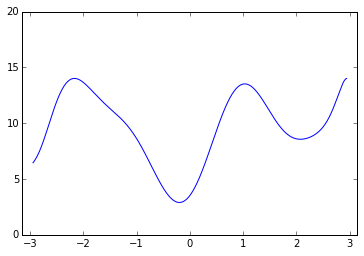

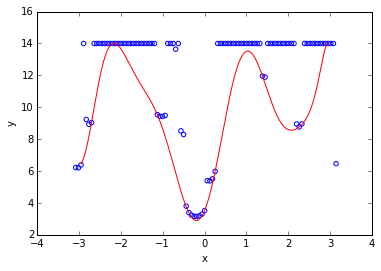

In [58]:
no_weights = laserDepths * 1.0
for index, value in enumerate(no_weights):
    no_weights[index] = 1.0
W_pete_no_weights = np.diag(no_weights)

# P = A^T W A
P_no_weights = cvxopt.matrix(A_pete.T * W_pete_no_weights * A_pete)

# q^T = -b^T A
# q = -A^T b
q_no_weights = cvxopt.matrix(- A_pete.T * W_pete_no_weights *b_pete.T)

# find the solution 
solution = cvxopt.solvers.qp(P_no_weights, q_no_weights, G, h)

alpha_no_weights = np.array(solution['x'])

print alpha_no_weights
    
plotHorner(alpha_no_weights)
    
plotConstrained(alpha_no_weights)    
